# `multidms` usage examples

This page documents and demonstrates various steps in the suggested analysis workflow when using `multidms`, including:
1. `Data` class
2. `Model` class
3. `fit_model` \& `fit_models` utilities
4. `ModelCollection` class


**Note**:

Here, we use data from [deep mutational scanning experiments](https://github.com/dms-vep) across 3 different homologs of the SARS-CoV-2 Spike protein. This analysis is only run on a subset of this data for the purpose of this example. For the full analysis run in our [manuscript](https://www.biorxiv.org/content/10.1101/2023.07.31.551037v1), see the manuscript analysis page at https://matsengrp.github.io/SARS-CoV-2_spike_multidms/. 

In [1]:
import pickle
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as onp

import multidms

In [3]:
%matplotlib inline
warnings.simplefilter('ignore')

## `Data` class

In order to fit a model, we first need to prep our training data in the form of a `multidms.Data` object. We keep the static data object separate from the model objects so that multiple `multidms.Model` objects may efficiently share references to the same fitting data, thus minimizing the memory and computations required to prep and store the data. A full description of the options for data prep and the resulting object attributes are available via the API documentation, or directly from the python docstring directly via
```python
help(multidms.Data)
```



You can initialize a `Data` object with a ``pd.DataFrame``
where each row is sampled variant with the following required columns:

1. **condition** - Experimental condition from
    which a sample measurement was obtained.
2. **aa_substitutions** - Defines each variant $v$ as a string of substitutions (e.g., 'M3A K5G').
    Note that while conditions may have differing wild types
    at a given site, the sites between conditions should reference
    the same site when alignment is performed between
    condition wild types. Finally, be sure wildtype variants have an empty string in this column
3. **func_score** - The functional score computed from experimental
    measurements.


In [4]:
func_score_df = pd.read_csv("func_score_df_delta_BA1_10K.csv").fillna("")
func_score_df

func_score                aa_substitutions      condition
0        -0.9770               T29S V622M D1199Y        Delta-2
1        -0.1607  N87K A846S K947R T1117R L1203F        Delta-2
2        -3.5000   S46T Q506- A845R A879V N1192D        Delta-2
3        -1.9102               L10P V327F I1179V        Delta-2
4         1.0093                     Q474H S686-        Delta-2
...          ...                             ...            ...
9995      0.8023                                  Omicron_BA1-2
9996      0.3779                                  Omicron_BA1-2
9997     -0.9409                          V1176S  Omicron_BA1-2
9998      0.1793                    A484L H1088Y  Omicron_BA1-2
9999     -0.9141                     N450D P479T  Omicron_BA1-2

[10000 rows x 3 columns]

Note that here we have multiple measurements for identical variants from individual barcode replicates

In [5]:
func_score_df.aa_substitutions.value_counts()

aa_substitutions
                      1567
D142S                    7
P26L                     7
T76I                     6
L368I                    6
                      ... 
E702V V736M              1
A1080V                   1
D178R P621R D796S        1
F329S K854N K1191T       1
N450D P479T              1
Name: count, Length: 7637, dtype: int64


Next, we'll initialize the dataset using 'Delta-2' as the reference condition.
Upon instantiation the object performs the data preparation which can be summarized as:

1. Optionally, aggregating identical variants grouped by aa string and condition. 
2. Inferring the site map each condition, so as to identify the wildtype of the reference and non-identical sites for each non-reference condition.
3. Converting substitution string of non-reference condition variants to be with respect to a reference wildtype (if necessary). See the docstring for a more in-depth description and a toy example
4. Setting helpful _static_ attributes with helpful summaries of the data. We'll take a look at a few notable attributes below.
5. initializing the raw training data as [binarymap](https://github.com/jbloomlab/binarymap) objects. Each condition will be associated with it's own `binarymap` which all share the same [allowed_subs](https://jbloomlab.github.io/binarymap/binarymap.binarymap.html?highlight=allowed).

In [6]:
data = multidms.Data(
    func_score_df,
    alphabet = multidms.AAS_WITHSTOP_WITHGAP, # AAS, AA_WITHSTOP, AA_WITHGAP, or AA_WITHSTOP_WITHGAP
    collapse_identical_variants = "mean", # False, "median"
    reference = "Delta-2", # any condition
    verbose = True, # progress bars
    nb_workers=4 # threads
)

inferring site map for Delta-2


  0%|          | 0/4094 [00:00<?, ?it/s]

inferring site map for Omicron_BA1-2


  0%|          | 0/3764 [00:00<?, ?it/s]

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [1007, 412, 865, 824, 774, 736, 347, 302, 559, 313, 1039, 991, 663, 419, 864, 418, 70, 805, 144, 319, 69, 916, 1053, 978, 143, 211, 301, 361, 379, 432, 538, 700, 637, 592, 145, 1218, 509, 877, 669, 278, 355, 360, 325, 776, 398, 40, 980, 456, 745, 584, 1145, 1062, 321, 194, 561, 497, 693, 543, 975, 906, 822, 931, 454, 295, 296, 437, 495, 434, 624, 742, 424, 873, 802, 972, 223, 270, 425, 461, 48, 753, 966, 974, 125, 786, 953, 524, 777, 500, 548, 380, 507, 914, 610, 130, 755, 433, 297, 377, 1119, 383, 698, 730, 531, 1031, 602, 763, 492, 695, 511, 1064, 525, 781, 760, 904, 526, 896, 964, 898, 157, 806, 1154, 467, 191, 1003, 833, 872, 416, 431, 891, 557, 729, 233, 887, 923, 965, 562, 816, 997, 959, 122, 158, 343, 726, 546, 749, 782, 728, 1011, 480, 992, 665, 905, 599, 928, 581, 696, 541, 236, 421, 756, 917, 91],
dropping: 567 variantswhich have mutations at those sites.


invalid non-identical-sites: [212, 371, 375, 417, 452, 477, 484, 493, 498, 981], dropping 475 variants
Converting mutations for Delta-2
is reference, skipping
Converting mutations for Omicron_BA1-2


Let's take a look at a few attributes now available through the data object.

`Data.site_map` gives us the wildtype sequence inferred from each observed substitutions observed in the data separately for each condition.

In [7]:
data.site_map.head()

Delta-2 Omicron_BA1-2
1       M             M
2       F             F
3       V             V
4       F             F
5       L             L

While the site map above gives the entire wildtype for each condition, we can easily view the sites for which a given condition wildtype differs from that of the reference via `Data.non_identical_sites`.

In [8]:
data.non_identical_sites['Omicron_BA1-2'].head()

Delta-2 Omicron_BA1-2
19        R             T
67        A             V
95        T             I
156       G             E
339       G             D

The set of all mutations we are able to learn about with this model is defined by all mutations seen across all variants, for all condition groups combined. Mutations observed at non-identical sites on non-reference condition variants are converted to be with respect to the reference wildtype at that site, in other words they are treated, reported, and encoded in the binarymap as if the substitution had occurred on the reference background. To get a succinct tuple of all mutations seen in the data, we can use `Data.mutations` attribute

In [9]:
data.mutations[:5]

('M1I', 'M1-', 'F2L', 'F2Y', 'V3F')

Perhaps more useful, `multidms.Data.mutations_df` gives more mutation-specific details, primarily the number of variant backgrounds any given mutation has been seen on, for each condition.

In [10]:
data.mutations_df.head()

mutation wts  sites muts  times_seen_Delta-2  times_seen_Omicron_BA1-2
0      M1I   M      1    I                 0.0                       1.0
1      M1-   M      1    -                 1.0                       0.0
2      F2L   F      2    L                 1.0                       1.0
3      F2Y   F      2    Y                 1.0                       0.0
4      V3F   V      3    F                 1.0                       4.0

`Data.variants_df` gives us all variants after the various data prepping options such as barcode aggregation, have been applied. See the API documentation for more.

In [11]:
data.variants_df.head()

condition aa_substitutions  weight  func_score    var_wrt_ref
0   Delta-2                      599    -0.15963               
1   Delta-2           A1016S       1    -1.29760         A1016S
2   Delta-2           A1016T       1    -0.88240         A1016T
3   Delta-2    A1016T K1191L       1    -0.03900  A1016T K1191L
4   Delta-2           A1020C       1     0.50800         A1020C

The 'weight' column above gives the number of barcodes that were seen for a given variant before they and their respective functional scores were aggregated. The 'var_wrt_ref' columns shows the converted 'aa_substitutions' to be with respect to the reference as described above. Above, we just see a few reference variants, thus there is no conversion applied. Let's look at a non-reference condition variant with a non-identical site mutation.

In [12]:
data.variants_df.query("condition == 'Omicron_BA1-2' and aa_substitutions.str.contains('212')").head()

condition         aa_substitutions  weight  func_score  \
6545  Omicron_BA1-2  Q23L I285F W633R W1212L       1     -3.5000   
6831  Omicron_BA1-2             S162I W1212L       1     -2.1074   

                                            var_wrt_ref  
6545  R19T A67V T95I G156E G339D S373P N440K G446S G...  
6831  R19T A67V T95I G156E G339D S373P N440K G446S G...

In the conversion, we see all that the "bundle" of mutations which distinguish Omicron BA1 from Delta are now encoded as if they were simply mutations seen on a Delta background with some exceptions. Notice that the variant at index $4116$ had a "I212A" mutation. That mutation is now encoded as "L212A", which exemplifies a substitution that has been converted to be with respect to the reference wildtype, "L", at site 212. Conversely, if the mutation at a non-identical site results in homology with the reference wildtype, then that site's substitutions is left out completely from the conversion. For example, the variant at index $4458$ contains the substitution "I212L", but there is no 212 substitution observed in the respective conversion.

## `Model` class

The `Model` object initializes and stores the model parameters determined by the mutations observed in the data, as well as the post-latent model specified. A full description of the options for models and the resulting object attributes are available via the API documentation, or directly from the python docstring directly via
```python
help(multidms.Model)
```

**Note**:

Parameter initialization is a deterministic generation process in which starting values are sampled from a distribution using the [jax.random](https://jax.readthedocs.io/en/latest/jax.random.html) module. You may optionally set a "seed" PRNG Key of your choosing, by default the Key is 0.

Next, we'll create the default model by simply passing the `Data` object created above.

In [13]:
model = multidms.Model(data)

So far, we have not fit the parameters to the data. The most flexible option for fitting to the data is to use the `Model.fit` method directly, like so:

In [14]:
model.fit(maxiter=15000)

This method uses the [jaxopt.ProximalGradient](https://jaxopt.github.io/stable/_autosummary/jaxopt.ProximalGradient.html) optimizer to fit the parameters (in place) to the data. Note that later we'll introduce the `model_collection` module interface for a more streamlined approach to creating and fitting one or more `Model` objects -- but the attributes and methods of individual `Model` objects are still be quite useful. 

For example, the `Model` object allows provides many of the same properties, like mutations and variants dataframes, but add additional features relevant to the parameters of this model. `Model.mutations_df` returns the associated data object's mutations_df as seen above, along with the $\beta$ and $S_{m,h}$ parameter's associated with each mutation. 

In [15]:
help(multidms.Model.mutations_df)

Help on function mutations_df in module multidms.model:

mutations_df(self, phenotype_as_effect=True, times_seen_threshold=0, return_split=True)
    Mutation attributes and phenotypic effects.
    
    Parameters
    ----------
    phenotype_as_effect : bool, optional
        if True, phenotypes (both latent, and func_score)
        are calculated as the _difference_ between predicted
        phenotype of a given variant and the respective experimental
        wildtype prediction. Otherwise, report the unmodified
        model prediction.
    times_seen_threshold : int, optional
        Only report mutations that have been seen at least
        this many times in each condition. Defaults to 0.
    return_split : bool, optional
        If True, return the split mutations as separate columns:
        'wts', 'sites', and 'muts'.
        Defaults to True.
    
    Returns
    -------
    pandas.DataFrame
        A copy of the mutations data, `self.data.mutations_df`,
        with the mutat

In [16]:
model.mutations_df(phenotype_as_effect=False).head()

beta  shift_Omicron_BA1-2  predicted_func_score_Delta-2  \
mutation                                                                 
M1I       -4.897398            -0.009559                     -3.227453   
M1-      -15.076238             0.000000                     -3.498683   
F2L        6.499686            -0.002973                      0.760441   
F2Y        7.830030             0.000000                      0.760958   
V3F        0.289656            -1.952068                      0.437663   

          predicted_func_score_Omicron_BA1-2  times_seen_Delta-2  \
mutation                                                           
M1I                                -3.229870                 0.0   
M1-                                -3.498683                 1.0   
F2L                                 0.760439                 1.0   
F2Y                                 0.760958                 1.0   
V3F                                -0.800541                 1.0   

          times_seen_Omicron_BA1-2 wts  sites muts  
mutation                                            
M1I                            1.0   M      1    I  
M1-                            0.0   M      1    -  
F2L                            1.0   F      2    L  
F2Y                            0.0   F      2    Y  
V3F                            4.0   V      3    F

Similarly, `Model.variants_df` now provides the latent ($z$) and functional score ($\hat{y}_{v, h}$) predictions as well as gamma-corrected functional score ($y'_{v, h}$). See the Biophysical documentation for more. Note that for the reference condition, $\gamma_{h}$ is always equal to $0$, and thus the functional score is always equal to the gamma corrected functional scores for these variants.

In [17]:
help(multidms.Model.variants_df)

Help on function variants_df in module multidms.model:

variants_df(self, phenotype_as_effect=True)
    Training data with model predictions for latent,
    and functional score phenotypes.
    
    Parameters
    ----------
    phenotype_as_effect : bool
        if True, phenotypes (both latent, and func_score)
        are calculated as the _difference_ between predicted
        phenotype of a given variant and the respective experimental
        wildtype prediction. Otherwise, report the unmodified
        model prediction.
    
    Returns
    -------
    pandas.DataFrame
        A copy of the training data, `self.data.variants_df`,
        with the phenotypes added. Phenotypes are predicted
        based on the current state of the model.



In [18]:
model.variants_df(phenotype_as_effect=False).head()

condition aa_substitutions  weight  func_score    var_wrt_ref  \
0   Delta-2                      599    -0.15963                  
1   Delta-2           A1016S       1    -1.29760         A1016S   
2   Delta-2           A1016T       1    -0.88240         A1016T   
3   Delta-2    A1016T K1191L       1    -0.03900  A1016T K1191L   
4   Delta-2           A1020C       1     0.50800         A1020C   

   predicted_latent  predicted_func_score  
0          2.209213              0.339735  
1          0.090485             -1.272478  
2          0.598338             -0.749924  
3          1.250767             -0.186957  
4          3.341482              0.615564

One other particularly useful method for making predictions on held-out validation, or testing data is `Model.add_phenotypes_to_df`. See 
```python
help(Model.add_phenotypes_to_df)
```
for details on this method.

In addition to the functions above which return raw `DataFrames`, there exists a few useful plotting methods for the Model object. Each plotting method will either populate a provided `matplotlib.axes` object provided, or generate it's own. For a full description of the plotting methods please see the API documentation.

First, let's take a look at the prediction accuracy on all training data as well as the global epistasis fit

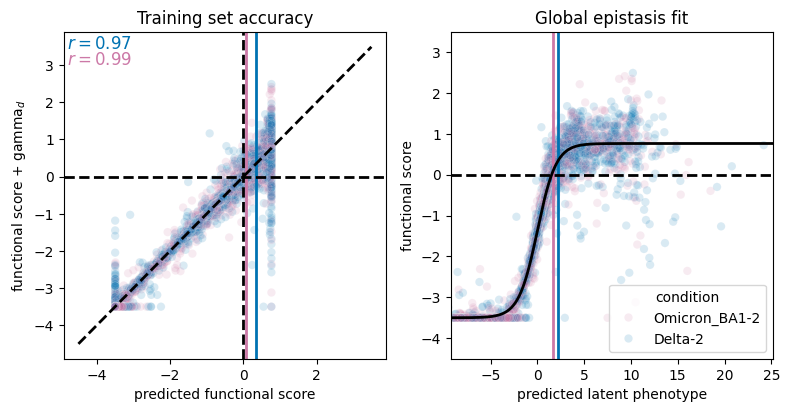

In [19]:
fig, ax = plt.subplots(1, 2, figsize=[8,4])
model.plot_epistasis(ax=ax[1], alpha=0.15, show=False, legend=True)
model.plot_pred_accuracy(ax=ax[0], alpha=0.15, show=False, legend=False)
ax[1].set_title("Global epistasis fit")
ax[0].set_title("Training set accuracy")
plt.show()

We can also take a quick look at the distribution of any parameter set in the model. Below we'll take a look at the distribution of shift parameters for the non reference BA1 condition. The distribution, by default, splits the shifts associated with stop codon mutations as a sanity check for the model fit. We expect stop codons to be equally deleterious no matter which condition they occur in, and thus, they should primarily be zero.

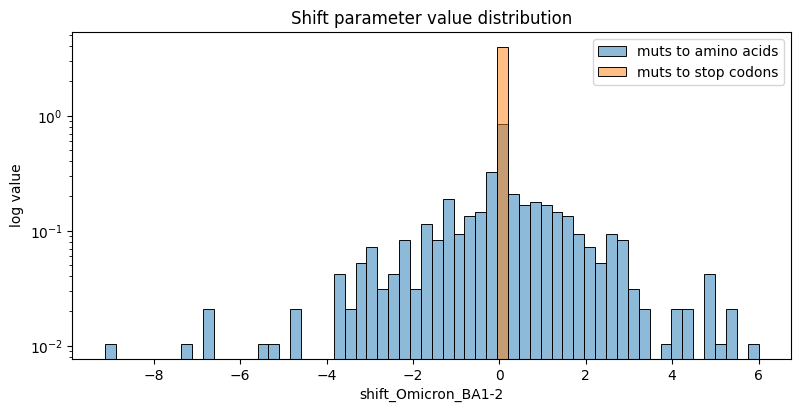

In [20]:
fig, ax = plt.subplots(figsize=[8,4])
agg_func = lambda x: onp.abs(onp.mean(onp.sum(x)))
model.plot_param_hist("shift_Omicron_BA1-2", ax=ax, show=False)
ax.set_yscale("log")
ax.legend()
ax.set_ylabel("log value")
ax.set_title("Shift parameter value distribution")
plt.show()

Perhaps the best way to explore parameter values associated with individual mutations, is `Model.mut_shift_plot()` which offers the ability to interactively visualize a model's _beta_ ($\beta_m$), experimental _shift_ ($\Delta_{d,m}$), and _phenotype_ predictions ($\hat{y}_{m, d}$). The plot is interactive, and allows you to hover over a mutation to see the associated values. The plot also allows you to zoom in on a region of interest using the site zoom bar. 

In [23]:
model.mut_param_heatmap(mut_param="beta")

alt.VConcatChart(...)

Note that the reference experimental wildtype's are marked with an 'x', below we visualize the shift parameters associated with the non-reference experiment. You'll note that at site where the two experiment wildtypes differ, we mark the non-reference wildtype with a colored 'o'. 

In [24]:
model.mut_param_heatmap(mut_param="shift")

alt.VConcatChart(...)

In [25]:
model.mut_param_heatmap(mut_param="predicted_func_score")

alt.VConcatChart(...)

Finally, we can save the tuned model via `pickle` (be sure to note the multidms version before dumping - Here be dragons). 

In [26]:
import pickle
pickle.dump(model, open(f"example_model_{multidms.__version__}.pkl","wb"))

## `fit_model` \& `fit_models` utilities

<!-- A key feature of global epistasis-like modeling, is the interpretable parameter values associated with any given mutation -- most commonly referred to as _mutations effects_. The joint-modeling approach in `multidms` provides mutation effect parameters for a given reference experiment, in addition to a respective set of shift parameters for _each_ non-reference experiment in the training data. 

As with many machine learning tasks it is beneficial to perform hyper-parameter sweeps and train on multiple datasets for cross validation. 
Here we introduce an interface to training `Model` objects  -->

In the [previous example notebook](https://matsengrp.github.io/multidms/fit_delta_BA1_example.html), we saw an explanation of the `Data` and `Model` class for fitting, and visualizing the results from a single model. Here, we will see how to use the `ModelCollection` class and associated utilities to fit multiple models (in parallel using `multiprocessing`) for aggregation and comparison of the results between fits. 

Two very common use cases for this interface include:

1. Shrinkage analysis of lasso coefficient values
2. Training on distinct replicate training datasets

To give an example of each below, we use the `multidms.fit_models` function to get a collection of 
fits (in the form of a `pandas.DataFrame` object) spanning two replicate datasets, and a range of lasso coefficient values.
We then instantiate a `multidms.ModelCollection` object from these fits to aggregate and visualize the results from the fits.

**Note**

This module functionally wraps the `Model` interface for convenience. If you're training on cpu's and have more than one core in your machine then this is definitely way to go. Currently, the code doesn't do anything clever to optimize GPU usage by many models training in parallel. If you wanted to use a pipeline to farm out the fitting processes independently, the same `DataFrame` could be acquired by collecting the individual `Series` objects returned by `fit_one_model`,
then concatenated using the simple `multidms.model_collection.stack_fit_models` utility function - all of which are demonstrated below.

In the previous example, we showed data from two conditions, and fit a single model to the data. Here, we'll load multiple replicates of that same data from [three deep mutational scanning experiments](https://github.com/dms-vep) across Delta, Omicron BA.1, and BA.2 Spike protein.

In [27]:
func_score_df = pd.read_csv("docs_func_score_df_delta_BA1_BA2.csv").fillna("")
func_score_df

func_score               aa_substitutions     condition  replicate  \
0          -0.5087               L24V F486L D820E         Delta          1   
1          -0.1940                         N1125K         Delta          1   
2           0.9906   V16I D138C F456Y T678S E990D         Delta          1   
3          -0.6554         G75S T76I M731I L1004F         Delta          1   
4          -3.5000  L176S L229P K558R S975Y T998S         Delta          1   
...            ...                            ...           ...        ...   
432316     -0.7932             G614K Q762E Q1071R  Omicron_BA.2          2   
432317     -0.3706                          D339T  Omicron_BA.2          2   
432318     -0.6116     I358L T1006I T1066S T1077A  Omicron_BA.2          2   
432319     -0.4363             S408R R765L K1073E  Omicron_BA.2          2   
432320     -3.5000       S98A A570M D1163Y S1252C  Omicron_BA.2          2   

        n_subs  
0            3  
1            1  
2            5  
3            4  
4            5  
...        ...  
432316       3  
432317       1  
432318       4  
432319       3  
432320       4  

[432321 rows x 5 columns]

In [28]:
func_score_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432321 entries, 0 to 432320
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   func_score        432321 non-null  float64
 1   aa_substitutions  432321 non-null  object 
 2   condition         432321 non-null  object 
 3   replicate         432321 non-null  int64  
 4   n_subs            432321 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 16.5+ MB


We would like to create two replicate training datasets, each of which should consist of one replicate from each of the three experiments. For simplicity, we'll group the three experiments deriving from replicate '1' together, and similarly for replicate '2' -- keeping in mind there is no significance to the replicate names in this case.

We'll create the `Data` objects, as we've done before, but this time we'll create independent `Data` objects for each replicate. Keep in mind that when comparing across replicate datasets using the `multidms.ModelCollection` interface, it is best to keep the reference, and non-reference conditions consistent among datasets.

In [29]:
data_replicates = {
    rep: multidms.Data(
        func_score_df.query("replicate == @rep"),
        alphabet = multidms.AAS_WITHSTOP_WITHGAP,
        collapse_identical_variants = "mean",
        reference = "Delta",
        verbose = False,
        nb_workers=4,
        name = f"Replicate {rep}"
    )
    for rep in [1, 2]
}
from pprint import pprint 
pprint(data_replicates)

{1: Data(Replicate 1), 2: Data(Replicate 2)}


The `model_collection` module offers a simple interface to create and fit `Model` objects. First, Let's fit a single model to one of the `Data` replicates above. To do this, we'll simply need to define the model parameters. 

In [30]:
single_set_of_params = {
    "dataset": data_replicates[1], # only one replicate dataset
    "num_training_steps" : 1,
    "iterations_per_step": 15000, # Small number of iterations for purposes of this example
    "alpha_d" : True,
    "scale_coeff_ridge_alpha_d": 1e-3,
    "scale_coeff_lasso_shift": 1e-5,
}


For a full list and descriptions of available hyperparameters, see: 
```python
help(multidms.model_collection.fit_one_model)
``` 

With these, we can now fit a singular model

In [31]:
fit = multidms.model_collection.fit_one_model(**single_set_of_params)
fit

model                                                 Model(Model-1)
dataset_name                                             Replicate 1
step_loss                    [6.707913875579834, 0.6865768432617188]
epistatic_model                                              Sigmoid
output_activation                                           Identity
scale_coeff_lasso_shift                                      0.00001
scale_coeff_ridge_beta                                             0
scale_coeff_ridge_shift                                            0
scale_coeff_ridge_gamma                                            0
scale_coeff_ridge_alpha_d                                      0.001
scale_coeff_huber                                                  1
gamma_corrected                                                False
alpha_d                                                         True
init_beta_naught                                                 0.0
lock_beta_naught_at               

Now we have the `Model` object along with the associated hyperparameters that were fit the model to the replicate dataset. Let's take a look at the shifts's ($\Delta_{m, d}$) from this fit using the `Model.mut_param_heatmap` method.


In [32]:
fit.model.mut_param_heatmap(mut_param="shift")

alt.VConcatChart(...)

Currently, the `model_collection` interface offers two public functions: `fit_one_model`, as we saw above, and `fit_models`. The former is wrapped by the latter, and allows for multiple models to be fit in parallel by spawning child processes using `multiprocessing`. The `fit_models` function takes in a single dictionary which defines the parameter space of all models you wish to run. Each value in the dictionary must be a list of values, even in the case of singletons. This function will compute all combinations of the parameter space and pass each combination to `multidms.utils.fit_wrapper` to be run in parallel, thus only key-value pairs which match the `fit_one_model` kwargs are allowed. 

To exemplify this, let's again define the hyperparameters, but this time, we'll specify each value as a list of values to be fit in parallel.

In [33]:
collection_params = {
    "dataset": list(data_replicates.values()),
    "num_training_steps" : [1],
    "iterations_per_step": [15000],
    "output_activation" : ["Softplus"],
    "lower_bound" : [-3.5],
    "alpha_d" : [True],
    "scale_coeff_ridge_alpha_d": [1e-3],
    "scale_coeff_lasso_shift": [0.0, 1e-6, 1e-5, 5e-5, 1e-4, 1e-3],
}

Before we fit the models, let's take a look at what collection of models we're specifying with this dictionary by calling upon a "private" function `multidms.model_collection._explode_params_dict`. As implied by the "private" this functionality behavior is hidden from the user and is performed intrinsically when calling `fit_models`.

In [34]:
from pprint import pprint
pprint(multidms.model_collection._explode_params_dict(collection_params))

[{'alpha_d': True,
  'dataset': Data(Replicate 1),
  'iterations_per_step': 15000,
  'lower_bound': -3.5,
  'num_training_steps': 1,
  'output_activation': 'Softplus',
  'scale_coeff_lasso_shift': 0.0,
  'scale_coeff_ridge_alpha_d': 0.001},
 {'alpha_d': True,
  'dataset': Data(Replicate 1),
  'iterations_per_step': 15000,
  'lower_bound': -3.5,
  'num_training_steps': 1,
  'output_activation': 'Softplus',
  'scale_coeff_lasso_shift': 1e-06,
  'scale_coeff_ridge_alpha_d': 0.001},
 {'alpha_d': True,
  'dataset': Data(Replicate 1),
  'iterations_per_step': 15000,
  'lower_bound': -3.5,
  'num_training_steps': 1,
  'output_activation': 'Softplus',
  'scale_coeff_lasso_shift': 1e-05,
  'scale_coeff_ridge_alpha_d': 0.001},
 {'alpha_d': True,
  'dataset': Data(Replicate 1),
  'iterations_per_step': 15000,
  'lower_bound': -3.5,
  'num_training_steps': 1,
  'output_activation': 'Softplus',
  'scale_coeff_lasso_shift': 5e-05,
  'scale_coeff_ridge_alpha_d': 0.001},
 {'alpha_d': True,
  'dataset'

What is produced is a list of **kwargs to pass to `fit_one_model`. In this case there are 12 total models to fit (2 replicate datasets x 6 lasso strengths). To fit these models, we simply pass the `collection_params` to `fit_models` and specify the number of threads available to run the model fits in parallel.

In [35]:
n_fit, n_failed, fit_models = multidms.model_collection.fit_models(collection_params, n_threads=4)

The third object returned by `fit_models` is a `pandas.DataFrame` object which contains the results from each model fit by stacking the `pd.Series` objects as returned by `fit_one_model`. 

In [36]:
fit_models

model dataset_name                                 step_loss  \
0   Model(Model-0)  Replicate 1   [4.571287155151367, 0.6238023638725281]   
1   Model(Model-0)  Replicate 1   [4.571287155151367, 0.6282336115837097]   
2   Model(Model-0)  Replicate 1   [4.571287155151367, 0.6726276278495789]   
3   Model(Model-0)  Replicate 1   [4.571287155151367, 0.8288853168487549]   
4   Model(Model-1)  Replicate 1   [4.571287155151367, 0.8795142769813538]   
5   Model(Model-1)  Replicate 1   [4.571287155151367, 0.9037127494812012]   
6   Model(Model-1)  Replicate 2  [3.9341390132904053, 0.5897706747055054]   
7   Model(Model-1)  Replicate 2  [3.9341390132904053, 0.5946934819221497]   
8   Model(Model-2)  Replicate 2  [3.9341390132904053, 0.6400377750396729]   
9   Model(Model-2)  Replicate 2  [3.9341390132904053, 0.7173289656639099]   
10  Model(Model-2)  Replicate 2  [3.9341390132904053, 0.8550326824188232]   
11  Model(Model-2)  Replicate 2   [3.9341390132904053, 0.881784200668335]   

   epistatic_model output_activation scale_coeff_lasso_shift  \
0          Sigmoid          Softplus                     0.0   
1          Sigmoid          Softplus                0.000001   
2          Sigmoid          Softplus                 0.00001   
3          Sigmoid          Softplus                 0.00005   
4          Sigmoid          Softplus                  0.0001   
5          Sigmoid          Softplus                   0.001   
6          Sigmoid          Softplus                     0.0   
7          Sigmoid          Softplus                0.000001   
8          Sigmoid          Softplus                 0.00001   
9          Sigmoid          Softplus                 0.00005   
10         Sigmoid          Softplus                  0.0001   
11         Sigmoid          Softplus                   0.001   

   scale_coeff_ridge_beta scale_coeff_ridge_shift scale_coeff_ridge_gamma  \
0                       0                       0                       0   
1                       0                       0                       0   
2                       0                       0                       0   
3                       0                       0                       0   
4                       0                       0                       0   
5                       0                       0                       0   
6                       0                       0                       0   
7                       0                       0                       0   
8                       0                       0                       0   
9                       0                       0                       0   
10                      0                       0                       0   
11                      0                       0                       0   

   scale_coeff_ridge_alpha_d  ... gamma_corrected alpha_d init_beta_naught  \
0                      0.001  ...           False    True              0.0   
1                      0.001  ...           False    True              0.0   
2                      0.001  ...           False    True              0.0   
3                      0.001  ...           False    True              0.0   
4                      0.001  ...           False    True              0.0   
5                      0.001  ...           False    True              0.0   
6                      0.001  ...           False    True              0.0   
7                      0.001  ...           False    True              0.0   
8                      0.001  ...           False    True              0.0   
9                      0.001  ...           False    True              0.0   
10                     0.001  ...           False    True              0.0   
11                     0.001  ...           False    True              0.0   

   lock_beta_naught_at     tol num_training_steps iterations_per_step  \
0                 None  0.0001                  1               15000   
1              

This `DataFrame` is all that's necessary to create a `multidms.ModelCollection` object. 


## `ModelCollection` class

The dataframe returned by `fit_models` can be used to instantiate a `ModelCollection` object, which in turn allows for a simple interface for getting raw aggregated mutational data, and to visualize these data from the collection of fits. 

In [37]:
mc = multidms.ModelCollection(fit_models)

To get the aggregated, raw mutational data in a nice tidy format, `ModelCollection.split_apply_combine_muts` has a straightforward name for a simple goal. This function follows the [split-apply-combine](https://pandas.pydata.org/docs/user_guide/groupby.html) paradigm to the collection of individual mutational effects tables (our example currently has 6) while keeping the fit hyperparameters of interest, tied to the data.

In [38]:
combined_lasso_strengths = mc.split_apply_combine_muts(groupby=("dataset_name", "scale_coeff_lasso_shift"))
combined_lasso_strengths.head()

cache miss - this could take a moment


mutation      beta  shift_Omicron_BA.1  \
dataset_name scale_coeff_lasso_shift                                          
Replicate 1  0.0                       A1015D -4.263447           -4.168998   
             0.0                       A1015Q -6.989111           -3.998795   
             0.0                       A1015S -0.019358           -1.080333   
             0.0                       A1015T -9.385324           -1.990580   
             0.0                       A1015V -4.685401           -4.448816   

                                      shift_Omicron_BA.2  \
dataset_name scale_coeff_lasso_shift                       
Replicate 1  0.0                               -0.246434   
             0.0                                0.000000   
             0.0                               -0.496059   
             0.0                                1.863133   
             0.0                               -1.000862   

                                      predicted_func_score_Delta  \
dataset_name scale_coeff_lasso_shift                               
Replicate 1  0.0                                       -1.940598   
             0.0                                       -3.151047   
             0.0                                       -0.001317   
             0.0                                       -3.275185   
             0.0                                       -2.263942   

                                      predicted_func_score_Omicron_BA.1  \
dataset_name scale_coeff_lasso_shift                                      
Replicate 1  0.0                                              -3.193376   
             0.0                                              -3.223423   
             0.0                                              -0.068060   
             0.0                                              -3.224236   
             0.0                                              -3.209804   

                                      predicted_func_score_Omicron_BA.2  \
dataset_name scale_coeff_lasso_shift                                      
Replicate 1  0.0                                              -2.054570   
             0.0                                              -3.069028   
             0.0                                               0.037278   
             0.0                                              -3.124743   
             0.0                                              -2.743822   

                                      times_seen_Delta  \
dataset_name scale_coeff_lasso_shift                     
Replicate 1  0.0                                   5.0   
             0.0                                   0.0   
             0.0                                   8.0   
             0.0                                   7.0   
             0.0                                   0.0   

                                      times_seen_Omicron_BA.1  \
dataset_name scale_coeff_lasso_shift                            
Replicate 1  0.0                                          2.0   
             0.0                                          8.0   
             0.0                                         22.0   
             0.0                                         12.0   
             0.0                                          6.0   

                                      times_seen_Omicron_BA.2  
dataset_name scale_coeff_lasso_shift                           
Replicate 1  0.0                                          3.0  
             0.0                                          0.0  
             0.0                                         29.0  
             0.0                                         22.0  
             0.0                                          7.0

The fit collection groupby features ("scale_coeff_lasso_shift", and "dataset_name" in this case, and by default) are set as a [multiindex](https://pandas.pydata.org/docs/user_guide/advanced.html) -- the index then easily distinguishes _fit groups_ from from _mutation features_, and is more memory efficient. Also note that by default, only mutations shared by all datasets are returned, but this can be changed by setting `inner_merge_dataset_muts=False`.

While the raw data is nice for custom visualizations, the `ModelCollection` class offers a few plotting methods to quickly visualize the results from the collection of fits. In this example, we fit a collection of models across two replicate datasets, and a range of lasso coefficient values, but we may next wonder which of these strengths presents the best results? To answer this, let's first take a look at the parameter correlation between replicate fits at each lasso coefficient value using `ModelCollection.mut_param_dataset_correlation`.

In [39]:
corr_df = mc.mut_param_dataset_correlation(times_seen_threshold=3, width_scalar=350, height=300)
corr_df

cache miss - this could take a moment


alt.FacetChart(...)

Here, we can see that the shift (green and yellow in this case) parameter correlation increases with the strength of the lasso coefficient. At the highest value for the lasso coefficient, however, there is no correlation as the lasso penalty is so strong that all shift parameters are all driven to zero. This behavior exemplifies the sparsity (number of values equal to 0) of the parameters. To further investigate the sparsity, we can use `ModelCollection.shift_sparsity` to visualize the sparsity of the shift parameters across the collection of fits.

In [40]:
mc.shift_sparsity(times_seen_threshold=3)

alt.FacetChart(...)

The sparsity chart groups the mutations types as either "nonsynonymous", or "stop". This is because we often use the stop sparsity as a gauge on the false-positive rate of the model. In other words, we expect that mutations to stop codons to be equally deleterious in all three homolog experiments, thus, the shifts for these mutations should be driven to zero before the nonsynonymous mutations, generally. 

Given these two sets of results it seems like a reasonable penalty coefficient exists somewhere in the range ($5e-05$, $1e-04$).  

Just as you might use `Model.mut_param_heatmap` to visualize the mutation effects from a single model, you can use `ModelCollection.mut_param_heatmap` to visualize the aggregated mutation effects from a collection of models fit to multiple replicate datasets.

Using all defaults this would be called as follows:

```python
heatmap_chart = mc.mut_param_heatmap()
```

However, our current example fit collection has 3 different lasso strengths, which don't make sense to aggregate over. Thus, this call will result in:

```python
ValueError: invalid query, more than one unique hyper-parameter besides dataset_name
```

To fix this, we must subset out model collection such that we are only aggregating across different training datasets.

In [41]:
chart = mc.mut_param_heatmap(
    times_seen_threshold=3,
    query="scale_coeff_lasso_shift == 5e-5",
    mut_param="shift"
)
chart

cache miss - this could take a moment


alt.VConcatChart(...)

Of the results given above, it seems there's a few notable shifts when looking at the aggregate of the replicates. In the case where you want to see the parameter value for a few mutations of interest across all fits, you can use `ModelCollection.mut_param_traceplot` function. Let take a look at the a few of the notable mutations from the heatmap above.

In [42]:
mc.mut_param_traceplot(mutations = ["N542D", "D568N", "A846N", "N1173K"], mut_param="shift")

alt.FacetChart(...)